# Image Processing - SCC0251

## Assignment 02 - Image Filtering

Author: Enrique Gabriel da Silva Teles, 10724326


In [6]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

We have our main part of the program which will read the inputs, select which method will be used, check if the output image will be saved and compare the images using the RSE method:

In [ ]:
# read initial inputs
filename= str(input()).rstrip()
input_img = imageio.imread(filename)
method = int(input()) # 1, 2 or 3
save = int(input())


if method == 1:
    # read input
    n = int(input())
    s = float(input())
    r = float(input())

    # Bilateral filter
    output_img = bilateral_filter(input_img, n, s, r)

if method == 2:
    # read input
    c = float(input()) # >= 1
    kernel = int(input()) # 1 or 2

    kernel1 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    kernel2 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

    # Unsharp mask using the Laplacian Filter
    if(kernel == 1):
        output_img = unsharp(input_img, c, kernel1)
    elif(kernel == 2):
        output_img = unsharp(input_img, c, kernel2)

if method == 3:
    sig_row = float(input())
    sig_col = float(input())

    # Vignette Filter
    output_img = vignette(input_img, sig_row, sig_col)

# check if is going to save output image or not
if save == 1:
    imageio.imwrite('output_img.png', output_img)

# compare input and output images and print the root squared error
rse = compare(input_img, output_img)
print(rse)


### Method 1 - Bilateral Filter

To use the bilateral filter, first we will be computing the **spacial gaussian component** of size $n x n$. In order to get the relative position with the center we used:
```python
x_center = float(x - int((n-1)/2))
y_center = float(y - int((n-1)/2))
```

After that, we added the **zero-padding** with value $\frac{n-1}{2}$ to compute the convolution in all pixels without getting any errors.

Next, it's just computing the **convolution** and **remove the zero-pading** of the output image.

In [11]:
def gaussian_kernel(x, sig):
    return float(float(1/(2 * float(np.pi) * sig*sig)) * float(np.exp(-x*x/(2 * sig * sig))))


def bilateral_filter(img, n, s, r):
    N, M = img.shape

    spatial_g = np.zeros([n, n]).astype(float)

    # compute the spatial gaussian component
    for x in range(n):
        for y in range(n):
            x_center = float(x - int((n-1)/2))
            y_center = float(y - int((n-1)/2))
            dist = float(np.sqrt(float(x_center*x_center) +
                         float(y_center*y_center)))  # euclides distance
            spatial_g[x, y] = gaussian_kernel(dist, s)

    # apply the convolution
    a = int((n-1)/2)
    b = int((n-1)/2)

    # zero-padding
    img_padd = np.zeros([N+a+a, M+b+b]).astype(np.uint8)
    img_padd[a:-a, b:-b] = img

    # output image
    img_out = np.array(img_padd, copy=True).astype(float)

    # for every pixel in the image but the padding
    for x in range(a, N-a):
        for y in range(b, M-b):
            i_f = 0.
            w_p = 0.

            # for each neighbor
            for i in range(-a, a+1):
                for j in range(-b, b+1):
                    # range gaussian
                    diff = float(img_padd[x+i, y+j]) - float(img_padd[x, y])
                    rang_g = gaussian_kernel(float(diff), float(r))

                    # total value of the filter
                    w_i = rang_g * spatial_g[a + i, b + j]
                    w_p = w_p + w_i

                    i_f = i_f + (w_i * float(img_padd[x+i, y+j]))

            i_f = i_f / w_p
            img_out[x, y] = i_f

    # remove zero-padding and convert to uint8
    img_out = img_out[a:-a, b:-b]
    return img_out.astype(np.uint8)

#### examples

(-0.5, 149.5, 149.5, -0.5)

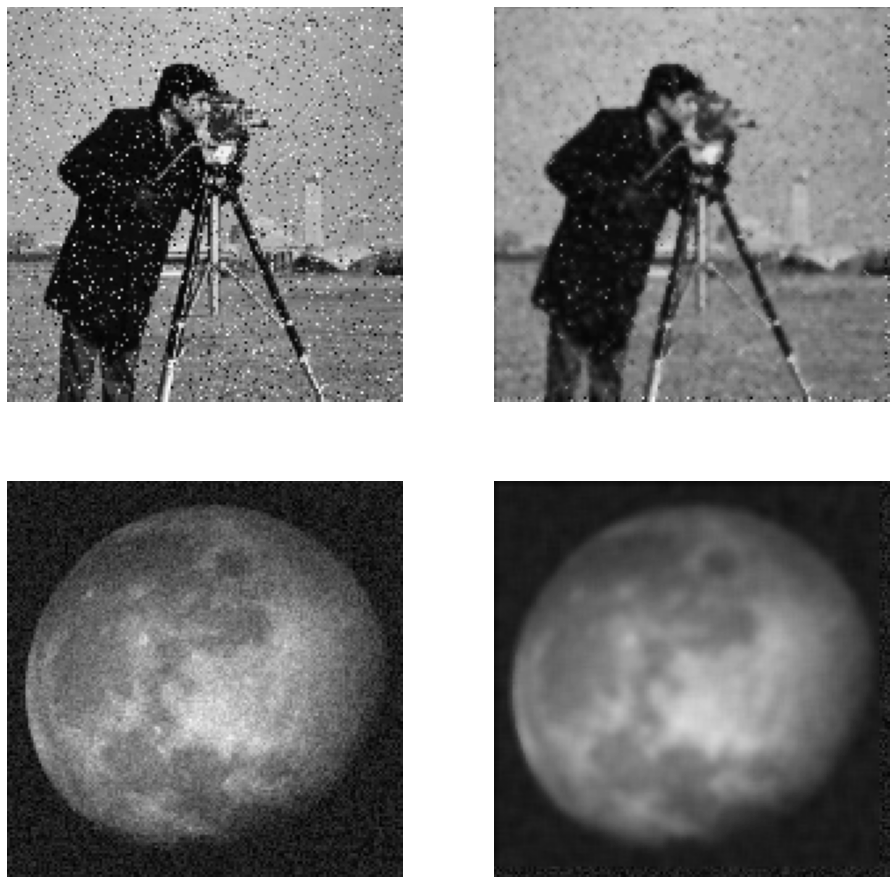

In [14]:
img1 = imageio.imread("images/camera.png")
img2 = imageio.imread("images/moon.png")

img1_bf = bilateral_filter(img1, 3, 150., 100.) # n = 3, s = 150., r = 100.0
img2_bf = bilateral_filter(img2, 5, 50., 100.) # n = 5, s = 50., r = 100.0

plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(222)
plt.imshow(img1_bf, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(223)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(224)
plt.imshow(img2_bf, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Method 2 - Unsharp mask using the Lapacian Filter

The unsharp function takes the *image*, the value *c* and the *kernel* as params. 
It will compute the **convolution** of the image first using the kernel and, as the method 1, we added the zero-padding to avoid errors and we flipped the kernel.
For each pixel we compute the output pixel *g* like this:
$$g(x,y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} kernel(s,t) \cdot f(x+s, y+t) $$

After that, we **normalize** the image and **added the _c_** value as instructed, and we finish by **scaling** the output image again. 

In [17]:
def convolution(img, kernel):
    N, M = img.shape
    n, m = kernel.shape

    a = int((n-1)/2)
    b = int((m-1)/2)

    # flip kernel
    kernel_flip = np.flip(np.flip(kernel, 0), 1)

    # add zero-padding
    img_padd = np.zeros([N+a+a, M+b+b]).astype(np.uint8)
    img_padd[a:-a, b:-b] = img

    # output image
    img_conv = np.zeros([img_padd.shape[0], img_padd.shape[1]]).astype(float)

    # for every pixel in the image but the padding
    for x in range(a, N-a):
        for y in range(b, M-b):
            # for each neighbor
            for i in range(-a, a+1):
                for j in range(-b, b+1):
                    img_conv[x, y] += img_padd[x+i, y+j] * kernel[a + i, b + j]
                    

    # remove zero-padding and convert to uint8
    img_conv = img_conv[a:-a, b:-b]
    return img_conv


def normalization(img):
    i_min = img.min()
    i_max = img.max()
    img_norm = (((img - i_min) * 255) / (i_max - i_min))
    return img_norm

def unsharp(img, c, kernel):
    img_out = convolution(img, kernel) # convolution
    img_out = normalization(img_out) # scaling

    img_out = (c * img_out) + img # adding
    img_out = normalization(img_out) # scalling

    return img_out.astype(np.uint8)

#### example

(-0.5, 299.5, 299.5, -0.5)

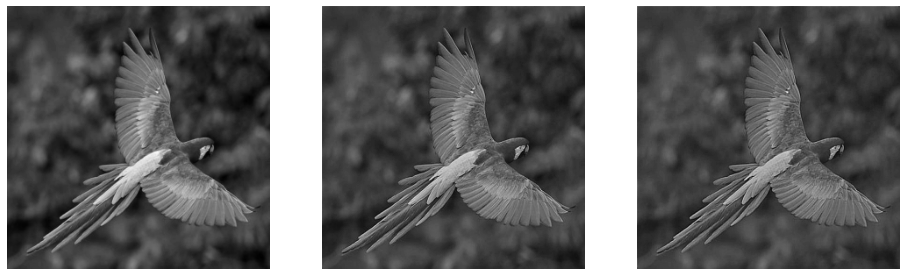

In [18]:
# the kernels
kernel1 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
kernel2 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

img3 = imageio.imread("images/arara.png")

img3_unsharp_1 = unsharp(img3, 0.5, kernel1) # c = 3
img3_unsharp_2 = unsharp(img3, 0.75, kernel2) # c = 5

plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(img3, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(img3_unsharp_1, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(img3_unsharp_2, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Method 3 - Vignette Filter
*(got wrong in run.codes)*

In order to compute the vignette filter we **compute two gaussian kernels** (one for the row and the other of the collumn) using the *gaussian_kernel* function centred at the $\frac{N}{2}-1$ if the size is even or $\frac{N-1}{2}$ if is odd.
Than we **transpose the row kernel** and multiply the transposed row kernel by the column kernel in order to **obtain a new matrix** with the same size as the image.

After that, we just **multiply** the new matrix by the input image and **normalize** it.

In [20]:
def vignette(img, sig_row, sig_col):
    N,M = img.shape
    
    # compute kernels
    w_row = np.zeros([N]).astype(float)
    w_col = np.zeros([M]).astype(float)

    if(N % 2 == 0):
        a = int((N/2) -1)
    else:
        a = int((N-1)/2)

    if(M % 2 == 0):
        b = int((M/2) -1)
    else:
        b = int((M-1)/2)


    # for each row
    for r in range(N):
        w_row[r] = gaussian_kernel(r-a, sig_row)

    # for each col
    for c in range(M):
        w_col[c] = gaussian_kernel(r-b, sig_col)

    # transpose
    t_row = w_row.transpose()
    w_new = np.multiply(t_row, w_col)
    

    img_out = (w_new * img).astype(float) 
    img_out = normalization(img_out)

    return img_out.astype(np.uint8)

#### example

(-0.5, 249.5, 249.5, -0.5)

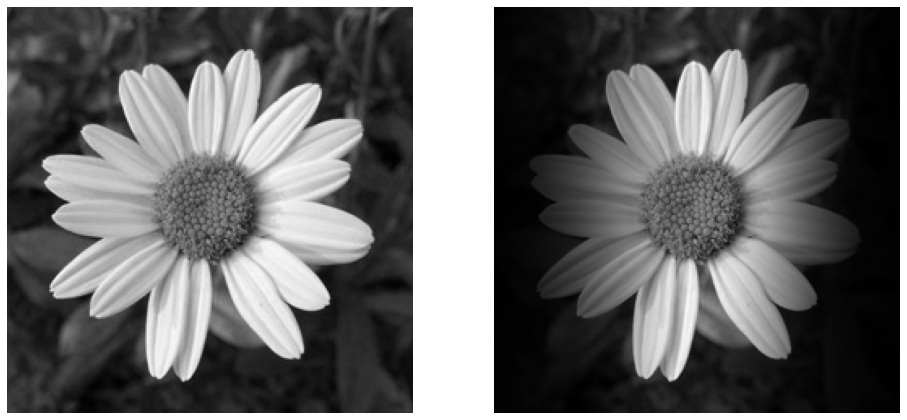

In [22]:
img4 = imageio.imread("images/flower.png")

img4_vignette = vignette(img4, 50., 50.) # sig_row = 50., sig_col = 50.

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(img4, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img4_vignette, cmap="gray", vmin=0, vmax=255)
plt.axis('off')